<h2>개인 구글 드라이브와 colab 연동</h2>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [2]:
!pip install pytorch-crf

root_dir = "/gdrive/My Drive/NLP/week5/6-2. POS Tagging"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


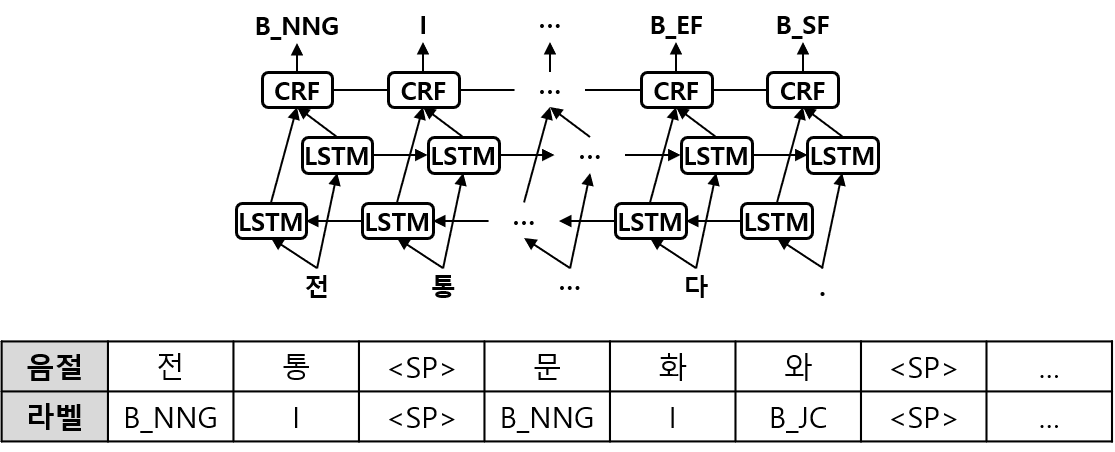

In [3]:
import os

from IPython.display import Image
Image(os.path.join(root_dir, "BiLSTM.png"))

<h2>BiLSTM_CRF 모델</h2>

In [4]:
import torch.nn as nn
from torchcrf import CRF


class BiLSTM_CRF(nn.Module):

    def __init__(self, config):
        super(BiLSTM_CRF, self).__init__() #부모의 생성자 가져옴

        # 전체 음절 개수
        self.eumjeol_vocab_size = config["eumjeol_vocab_size"]

        # 음절 임베딩 사이즈
        self.embedding_size = config["embedding_size"]

        # LSTM 히든 사이즈
        self.hidden_size = config["hidden_size"]

        # 분류할 태그의 개수
        self.number_of_tags = config["number_of_tags"]

        # 입력 데이터에 있는 각 음절 index를 대응하는 임베딩 벡터로 치환해주기 위한 임베딩 객체
        # 기존에 사전학습 된 음절 임베딩을 사용할 수도 있고 랜덤으로 초기화 한 후,
        # 모델 학습 과정 중에 같이 학습 시키는 것도 가능
        # 예제 코드는 랜덤으로 초기화 한 후 같이 학습하도록 설정
        self.embedding = nn.Embedding(num_embeddings=self.eumjeol_vocab_size, embedding_dim=self.embedding_size,
                                      padding_idx=0)

        # Bi-LSTM layer
        self.bi_lstm = nn.LSTM(input_size=self.embedding_size, hidden_size=self.hidden_size,
                               num_layers=3, batch_first=True, dropout=config["dropout"],
                               bidirectional=True) #bidirectional은 양방향 -> 3층을 쌓음 => 추상화 높이기 위해

        # fully_connected layer를 통하여 출력 크기를 number_of_tags에 맞춰줌
        # (batch_size, max_length, hidden_size*2) -> (batch_size, max_length, number_of_tags)
        self.hidden2num_tag = nn.Linear(in_features=self.hidden_size*2, out_features=self.number_of_tags)

        # CRF layer
        self.crf = CRF(num_tags=self.number_of_tags, batch_first=True) #crf개수는 tag개수만큼 - observation 확률값이 들어가야 하기 때문

    def forward(self, inputs, labels=None):
        # (batch_size, max_length) -> (batch_size, max_length, embedding_size)
        eumjeol_inputs = self.embedding(inputs)

        # 대응하는 임베딩 벡터로 치환한 음절 입력 벡터 시퀀스를 Bi-LSTM 계층의 입력으로 사용
        # Bi-LSTM 계층의 출력을 선형 함수의 입력으로 사용하여 태그 확률 분포로 변환
        #########################################

        # hidden_outputs:(batch_size, max_length, hidden_size)
        hidden_outputs, _ = self.bi_lstm(eumjeol_inputs) # cell state 사용 안함

        # (hidden_size, max_length, hidden_size*2) -> (batch_size, max_length, number_of_tags)
        hidden_outputs = self.hidden2num_tag(hidden_outputs)

        #########################################

        
        if(labels is not None): #train
            # 곱을 합으로 바꾸기 위해 log function 씌움움
            log_likelihood = self.crf(emissions=hidden_outputs, tags=labels, reduction="mean") # 정답 레이블에 해당하는 확률값들의 평균을 리턴(Log likelihood :-무한대 ~ 0.0)
            loss = log_likelihood * -1.0 # loss 함수로 만들기 위해 Negative Log Likelihood로 변경(무한대 ~ 0.0)

            return loss
        else: #test
            output = self.crf.decode(emissions=hidden_outputs) #hidden_outputs는 observation probability

            return output

<h2>데이터 읽고 전처리 하기</h2>

<pre>
<b>1. read_data(file_path)</b>
  "train_datas.txt", "test_datas.txt" 파일을 읽기 위한 함수
  
  데이터 예시)
    전 통 〈SP〉 문 화 와 〈SP〉 외 래 〈SP〉 ... \t B_NNG I 〈SP〉 B_NNG I B_JC 〈SP〉 B_NNG I 〈SP〉 ...
  
  read_data(file_path)
  args
    file_path : 읽고자 하는 데이터의 경로
  return
    음절 sequence, 각 음절에 대응하는 라벨 sequence를 담고 있는 리스트
    
    출력 예시)
      datas = [
        (['전', '통', '〈SP〉', '문', '화', '와', '〈SP〉', '외', '래', '〈SP〉', ...], ['B_NNG', 'I', '〈SP〉', 'B_NNG', 'I', 'B_JC', '〈SP〉', 'B_NNG', 'I', '〈SP〉', ...])

        (...),
        
        ]
      
<b>2. read_vocab_data(vocab_data_path)</b>
  "eumjeol_vocab.txt", "label_vocab.txt" 파일을 읽고 음절과 라벨을 indexing하기 위한 딕셔너리를 생성
   
  read_vocab_data(vocab_data_path)
  args
    vocab_data_path : 어휘 파일 경로
  return  
    term2idx : 라벨을 대응하는 index로 치환하기 위한 딕셔너리
    idx2term : index를 대응하는 라벨로 치환하기 위한 딕셔너리
    
<b>3. convert_data2feature(datas, max_length, eumjeol2idx, label2idx)</b>
  입력 데이터를 고정된 길이로 변환 후 indexing
  Tensor로 변환
   
  convert_data2feature(datas, max_length, eumjeol2idx, label2idx)
  args
    datas : 음절 sequence, 각 음절에 대응하는 라벨 sequence를 담고 있는 리스트
    max_length : 입력의 최대 길이
    eumjeol2idx : 음절을 대응하는 index로 치환하기 위한 딕셔너리
    label2idx : 라벨을 대응하는 index로 치환하기 위한 딕셔너리
  return
    입력 데이터와 각각의 데이터의 실제 길이를 담고 있는 Tensor
    
  전처리 예시)
    datas = [
        (['전', '통', '〈SP〉', '문', '화', '와', '〈SP〉', '외', '래', '〈SP〉', ...], ['B_NNG', 'I', '〈SP〉', 'B_NNG', 'I', 'B_JC', '〈SP〉', 'B_NNG', 'I', '〈SP〉', ...])

        (...),
        
        ]
    
    eumjeol_features : Tensor([1307, 1664, 15, 723, 1831, 1197, 15, 1208, ... ], [...], ...)
    label_features : Tensor([ 99, 199, 1, 99, 199, 54, 1, 99, 199, 1, 99, 199, ... ], [...], ...)
 </pre>


In [5]:
import torch
import numpy as np


# 학습 or 평가 데이터를 읽어 리스트에 저장
def read_data(file_path):
    with open(file_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    datas = []
    for line in lines:
        # 입력 문장을 \t으로 분리
        pieces = line.strip().split("\t")

        # 입력 문자열을 음절 단위로 분리
        eumjeol_sequence, label_sequence = pieces[0].split(), pieces[1].split()

        datas.append((eumjeol_sequence, label_sequence))

    return datas


# 데이터를 읽고 대응하는 딕셔너리 생성
def read_vocab_data(vocab_data_path):
    term2idx, idx2term = {}, {}

    with open(vocab_data_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    for line in lines:
        term = line.strip()
        term2idx[term] = len(term2idx)
        idx2term[term2idx[term]] = term

    return term2idx, idx2term


# 입력 데이터 전처리
def convert_data2feature(datas, max_length, eumjeol2idx, label2idx):
    # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터를 담을 리스트
    eumjeol_features, label_features = [], []

    for eumjeol_sequence, label_sequence in datas:

        # 사전 설정한 max_length의 길이를 갖는 numpy array 생성
        eumjeol_feature = np.zeros(shape=(max_length), dtype=int)
        label_feature = np.zeros(shape=(max_length), dtype=int)

        # 음절 sequence와 라벨 sequence의 각 값들을 index로 치환하고 위에서 생성한 numpy array에 저장
        for index in range(len(eumjeol_sequence[:max_length])):
            eumjeol_feature[index] = eumjeol2idx[eumjeol_sequence[index]]
            label_feature[index] = label2idx[label_sequence[index]]

        # 변환한 데이터를 각 리스트에 저장
        eumjeol_features.append(eumjeol_feature)
        label_features.append(label_feature)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    eumjeol_features = torch.tensor(np.array(eumjeol_features), dtype=torch.long)
    label_features = torch.tensor(np.array(label_features), dtype=torch.long)

    return eumjeol_features, label_features

<h2>BiLSTM_CRF 모델 학습</h2>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 학습 및 평가 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, eumjeol2idx, label2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. BiLSTM_CRF 모델 객체 선언</b>

<b>5. epoch 마다 학습한 모델 파일 저장</b>
</pre>

In [6]:
import numpy as np
import torch
from torch.utils.data import (DataLoader, TensorDataset, RandomSampler)
import torch.optim as optim


def train(config):
    # 학습 데이터 읽기
    train_datas = read_data(file_path=config["train_data_path"])

    # 음절 및 라벨 딕셔너리 생성
    eumjeol2idx, idx2eumjeol = read_vocab_data(vocab_data_path=config["eumjeol_vocab_data_path"])
    label2idx, idx2label = read_vocab_data(vocab_data_path=config["label_vocab_data_path"])

    # 입력 데이터 전처리
    train_eumjeol_features, train_label_features = convert_data2feature(datas=train_datas, max_length=config["max_length"],
                                                                        eumjeol2idx=eumjeol2idx, label2idx=label2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_dataset = TensorDataset(train_eumjeol_features, train_label_features)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=config["batch_size"],
                                  sampler=RandomSampler(train_dataset))

    # BiLSTM_CRF 모델 객체 생성
    model = BiLSTM_CRF(config).cuda()

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(config["epoch"]):
        model.train()

        losses = []
        for batch in train_dataloader:
            batch = tuple(t.cuda() for t in batch)

            # 음절 데이터, 라벨 데이터
            inputs, labels = batch[0], batch[1] # 음절, 정답

            # 모델 학습
            loss = model(inputs, labels) 

            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            optimizer.zero_grad()

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()

            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            # batch 단위 loss 값 저장
            losses.append(loss.data.item())

        torch.save(model.state_dict(), os.path.join(output_dir, "trained_model.pt"))

        # 평균 loss 출력
        print("Average loss : {}\n".format(np.mean(losses)))

<h2>BiLSTM_CRF 모델 평가</h2>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 평가 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, eumjeol2idx, label2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. BiLSTM_CRF 모델 객체 선언 후 기존에 학습한 모델 파일 불러옴</b>

<b>5. 학습한 BiLSTM_CRF 모델 평가</b>

</pre>

In [12]:
import torch
from torch.utils.data import (DataLoader, TensorDataset, SequentialSampler)


def test(config):
    # 평가 데이터 읽기
    test_datas = read_data(file_path=config["test_data_path"])

    # 음절 및 라벨 딕셔너리 생성
    eumjeol2idx, idx2eumjeol = read_vocab_data(vocab_data_path=config["eumjeol_vocab_data_path"])
    label2idx, idx2label = read_vocab_data(vocab_data_path=config["label_vocab_data_path"])

    test_eumjeol_features, test_label_features = convert_data2feature(datas=test_datas, max_length=config["max_length"],
                                                                      eumjeol2idx=eumjeol2idx, label2idx=label2idx)

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_dataset = TensorDataset(test_eumjeol_features, test_label_features)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, sampler=SequentialSampler(test_dataset))

    # BiLSTM_CRF 모델 객체 생성
    model = BiLSTM_CRF(config).cuda()
    # 사전학습한 모델 파일로부터 가중치 불러옴
    model.load_state_dict(torch.load(os.path.join(config["output_dir_path"], config["trained_model_name"])))

    model.eval()

    for batch in test_dataloader:
        batch = tuple(t.cuda() for t in batch)

        # 음절 데이터, 라벨 데이터
        inputs, labels = batch[0], batch[1] 

        # 모델 평가
        predicts = model(inputs)
        inputs, predicts, labels = inputs[0], predicts[0], labels[0]

        # Tensor를 numpy array로 변경하고 입력 데이터의 실제 길이만큼 추출
        inputs = inputs.cpu().numpy().tolist()
        labels = labels.cpu().numpy().tolist()

        input_length = config["max_length"] - inputs.count(0)

        inputs = [idx2eumjeol[piece] for piece in inputs[:input_length]]
        predicts = [idx2label[piece] for piece in predicts[:input_length]]
        labels = [idx2label[piece] for piece in labels[:input_length]]

        # print("inputs : {}".format(inputs))
        # print("predicts : {}".format(predicts))
        # print("labels : {}".format(labels))
        # print()

        predict_sentence = ""
        correct_sentence = ""
        for i in range(input_length):
          if (predicts[i] == "I"):
            continue
          if inputs[i] == "<SP>":
            predict_sentence += "{} ".format(inputs[i])
            correct_sentence += "{} ".format(inputs[i])
            continue
          predict_word = inputs[i]
          correct_word = inputs[i]
          j = i + 1
          while j < input_length and (predicts[j] == "I"):
            predict_word += inputs[j]
            correct_word += inputs[j]
            j += 1
          predict_sentence += "{}/{} ".format(predict_word, predicts[i].split("_")[-1])
          correct_sentence += "{}/{} ".format(correct_word, labels[i].split("_")[-1])

        print("predict_sentence : {}".format(predict_sentence))
        print("correct_sentence : {}".format(correct_sentence))
        print()
          

In [8]:
import os


if(__name__=="__main__"):
    root_dir = "/gdrive/My Drive/NLP/week5/6-2. POS Tagging"
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"mode": "train",
              "trained_model_name": "trained_model.pt",
              "train_data_path": os.path.join(root_dir, "train_datas.txt"),
              "test_data_path": os.path.join(root_dir, "test_datas.txt"),
              "output_dir_path": output_dir,
              "eumjeol_vocab_data_path": os.path.join(root_dir, "eumjeol_vocab.txt"),
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "eumjeol_vocab_size": 1892,
              "embedding_size": 128,
              "hidden_size": 128,
              "max_length": 100,
              "number_of_tags": 302,
              "epoch": 10,
              "batch_size": 64,
              "dropout": 0.1
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

/usr/local/lib/python3.9/dist-packages/torchcrf/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:493.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


Average loss : 95.73519559726594

Average loss : 27.266721506786954

Average loss : 12.098530246953295

Average loss : 7.160469407488586

Average loss : 5.35655473599768

Average loss : 4.357915161521571

Average loss : 3.6390140071796004

Average loss : 3.0959090093138872

Average loss : 2.6618112697722807

Average loss : 2.31587688786209



In [13]:
import os


if(__name__=="__main__"):
    root_dir = "/gdrive/My Drive/NLP/week5/6-2. POS Tagging"
    output_dir = os.path.join(root_dir, "output")
    save_dir = os.path.join(root_dir, "save")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"mode": "test",
              "trained_model_name": "trained_model.pt",
              "train_data_path": os.path.join(root_dir, "train_datas.txt"),
              "test_data_path": os.path.join(root_dir, "test_datas.txt"),
              "output_dir_path": output_dir,
              "save_dir_path": save_dir,
              "eumjeol_vocab_data_path": os.path.join(root_dir, "eumjeol_vocab.txt"),
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "eumjeol_vocab_size": 1892,
              "embedding_size": 128,
              "hidden_size": 128,
              "max_length": 100,
              "number_of_tags": 302,
              "epoch": 10,
              "batch_size": 64,
              "dropout": 0.1
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

predict_sentence : '/SS 외인/NNG <SP> 용병/NNG <SP> 최고/NNG 의/JKG <SP> 골잡이/NNG '/SS <SP> 라데/NP 와/JC <SP> 국가/NNG 대표/NNG <SP> 골게터/NNG <SP> 황선홍/NNP 의/JKG <SP> 올/NNG <SP> 시즌/NNG <SP> 골/NNG <SP> 소식/NNG 이/JKS <SP> 감감/NNG 하/XSA 다/EF ./SF 
correct_sentence : '/SS 외인/NNG <SP> 용병/NNG <SP> 최고/NNG 의/JKG <SP> 골잡이/NNG '/SS <SP> 라데/NNP 와/JC <SP> 국가/NNG 대표/NNG <SP> 골게터/NNG <SP> 황선홍/NNP 의/JKG <SP> 올/MM <SP> 시즌/NNG <SP> 골/NNG <SP> 소식/NNG 이/JKS <SP> 감감/MAG 하/XSA 다/EF ./SF 

predict_sentence : 자기/NP 가/JKS <SP> 신/NNG 은/JX <SP> 검은색/NNG <SP> 구두/NNG 를/JKO <SP> 내려다보/VV 면서/EF ./SF 
correct_sentence : 자기/NP 가/JKS <SP> 신/VV 은/ETM <SP> 검은색/NNG <SP> 구두/NNG 를/JKO <SP> 내려다보/VV 면서/EF ./SF 

predict_sentence : 방바닥/NNG 에/JKB <SP> 주저앉/VV 았/EP 습니다/EF ./SF 
correct_sentence : 방바닥/NNG 에/JKB <SP> 주저앉/VV 았/EP 습니다/EF ./SF 

predict_sentence : 그즈음/NNG <SP> 그/NP 들/XSN 이/JKS <SP> 워싱턴/MAG 을/JKO <SP> 거처/NNG 로/JKB <SP> 삼/VV 고/EC <SP> 있/VX 었/EP 다/EF ./SF 
correct_sentence : 그즈음/NNG <SP> 그/NP 들/XSN 이/JKS <SP> 워싱턴/NNP 을/JKO <SP> 거처/NNG 로/JK